# Modèle Regression Logistique

In [9]:
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 

import sys
sys.stdout.flush()

import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

from joblib import dump, load
import pickle
import os 
import shap
import importlib
import lime
from lime.lime_tabular import LimeTabularExplainer

In [10]:

def modelAlreadyTrain(filename):
    return os.path.isfile('../models/' + filename)

def savePickleModel(model, filename):
    with open('../models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

def loadPickleModel(filename):
    with open('../models/' + filename, 'rb') as f:
        model = pickle.load(f)
        f.close()
        return model

## Récupération des données 


In [11]:
df = pd.read_csv(r'C:\Users\mlska\Documents\PROJET\Co2_final.csv', header=0)
display(df.head())

median_value = df['Ewltp (g/km)'].median()

def calcTarget(X):
    if X <= median_value:
        return 0
    else:
        return 1
df['target'] = df['Ewltp (g/km)'].apply(lambda x: calcTarget(x))
df

,ID,Mp,T,m (kg),Ewltp (g/km),W (mm),At1 (mm),ec (cm3),ep (KW),Fuel consumption,...,Ft_diesel/electric,Ft_e85,Ft_lpg,Ft_ng,Ft_petrol,Ft_petrol/electric,Fm_F,Fm_H,Fm_M,Fm_P
0,77074142,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False
1,77074143,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False
2,77074144,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False
3,77074145,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False
4,77074146,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False


,ID,Mp,T,m (kg),Ewltp (g/km),W (mm),At1 (mm),ec (cm3),ep (KW),Fuel consumption,...,Ft_e85,Ft_lpg,Ft_ng,Ft_petrol,Ft_petrol/electric,Fm_F,Fm_H,Fm_M,Fm_P,target
0,77074142,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,0
1,77074143,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,0
2,77074144,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,0
3,77074145,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,0
4,77074146,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498781,86000028,0.148938,0.004701,940.0,113.0,2450.0,1430.0,1193.0,52.0,5.0,...,False,False,False,True,False,False,False,True,False,0
3498782,86000029,0.148938,0.004701,985.0,125.0,2450.0,1430.0,1193.0,52.0,5.5,...,False,False,False,True,False,False,False,True,False,0
3498783,86000030,0.148938,0.004701,985.0,125.0,2450.0,1430.0,1193.0,52.0,5.5,...,False,False,False,True,False,False,False,True,False,0
3498784,86000031,0.148938,0.004701,985.0,125.0,2450.0,1430.0,1193.0,52.0,5.5,...,False,False,False,True,False,False,False,True,False,0


### Création des jeux de données d'entrainement et des jeux de données de test

In [12]:

X = df.drop(columns=['Ewltp (g/km)', 'target', 'ID'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

> Mise à l'echelle des différentes valeurs

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [8]:

Clf = LogisticRegression()

# Paramètres pour la recherche de grille
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [500, 1000, 2000]
}

# Recherche de grille avec validation croisée
grid_search = GridSearchCV(Clf, param_grid, cv=5)
grid_search.fit(X_train_scaler, y_train)

# Extraction des scores de validation croisée et des meilleurs paramètres
cv_scores = grid_search.cv_results_['mean_test_score']
best_params = grid_search.best_params_

# Affichage des résultats
print("Meilleurs paramètres :", best_params)
print("Scores de validation croisée :", cv_scores)


Meilleurs paramètres : {'C': 100, 'max_iter': 500, 'solver': 'liblinear'}
Scores de validation croisée : [0.97364657 0.97357083 0.97444792 0.97364657 0.97357083 0.97444792
 0.97364657 0.97357083 0.97444792 0.98842169 0.98746994 0.98843456
 0.98842169 0.98746994 0.98843456 0.98842169 0.98746994 0.98843456
 0.99104975 0.99016016 0.99103582 0.99104975 0.99016016 0.99103582
 0.99104975 0.99016016 0.99103582 0.99110513 0.9908554  0.99112871
 0.99110513 0.9908554  0.99112871 0.99110513 0.9908554  0.99112871]


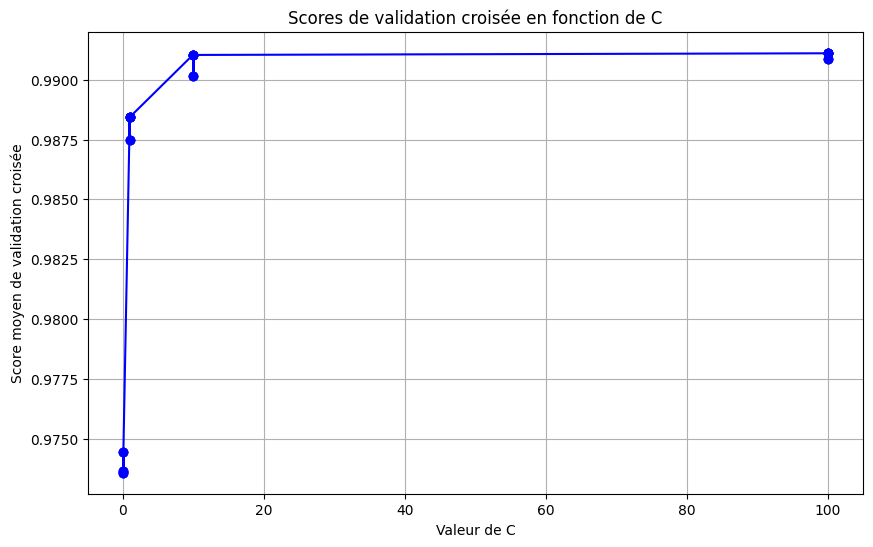

In [9]:
# Tracé du graphique des scores de validation croisée en fonction de C
mean_test_scores = grid_search.cv_results_['mean_test_score']
param_C = grid_search.cv_results_['param_C']

plt.figure(figsize=(10, 6))
plt.plot(param_C, mean_test_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Valeur de C')
plt.ylabel('Score moyen de validation croisée')
plt.title('Scores de validation croisée en fonction de C')
plt.grid(True)
plt.show()


### Entrainement du modèle

In [14]:
Clf = LogisticRegression(C=100, # C=100 indique une régularisation relativement faible.
                         random_state=42, # Fixe la graine de l'algorithme aléatoire pour assurer la reproductibilité des résultats
                         solver='liblinear', # L'algorithme utilisé pour optimiser le modèle de régression logistique.
                         max_iter=500) # Nombre maximum d'itérations que l'algorithme doit effectuer pour converger
Clf.fit(X_train_scaler, y_train)

LogisticRegression(C=100, max_iter=500, random_state=42, solver='liblinear')

In [8]:
savePickleModel(Clf, 'LogisticRegressor.pkl')

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

class ClassificationModel:
    def __init__(self, model_type, model, X_train, X_test, y_train, y_test, columns):
        self.model_type = model_type
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.columns = columns
        self.y_pred_test = None
        self.report = None

    def predictModel(self):
        self.y_pred_test = self.model.predict(self.X_test)

    def calcScore(self):
        # Calculer les métriques de performance
        accuracy = accuracy_score(self.y_test, self.y_pred_test)
        precision = precision_score(self.y_test, self.y_pred_test, pos_label=0, average='binary')
        recall = recall_score(self.y_test, self.y_pred_test, pos_label=0, average='binary')
        f1 = f1_score(self.y_test, self.y_pred_test, pos_label=0, average='binary')
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")


    def displayScore(self):
        class_mapping = {0: 'Faible pollution', 1: 'Forte pollution'}

        # Générer le rapport sous forme de dictionnaire
        self.report = classification_report(
            self.y_test,
            self.y_pred_test,
            target_names=[class_mapping[i] for i in sorted(class_mapping.keys())],
            output_dict=True
        )

        # Affichage du rapport complet
        print(classification_report(
            self.y_test,
            self.y_pred_test,
            target_names=[class_mapping[i] for i in sorted(class_mapping.keys())]
        ))



In [16]:
Clf = LogisticRegression(C=100, 
                         random_state=42, 
                         solver='liblinear', 
                         max_iter=500)

Model = ClassificationModel('LogisticRegression',
                               Clf, 
                               X_train_scaler, 
                               X_test_scaler, 
                               y_train, 
                               y_test, 
                               X.columns)

Model.model.fit(X_train_scaler, y_train)

Model.predictModel()
Model.calcScore()
Model.displayScore()

Accuracy: 0.9911569428288065
Precision: 0.9906357381051041
Recall: 0.9919107415529909
F1 Score: 0.9912728298427473
                  precision    recall  f1-score   support

Faible pollution       0.99      0.99      0.99    354297
 Forte pollution       0.99      0.99      0.99    345461

        accuracy                           0.99    699758
       macro avg       0.99      0.99      0.99    699758
    weighted avg       0.99      0.99      0.99    699758



### Représentation graphique des résultats du modèle
> Affichage de la matrice de confusion

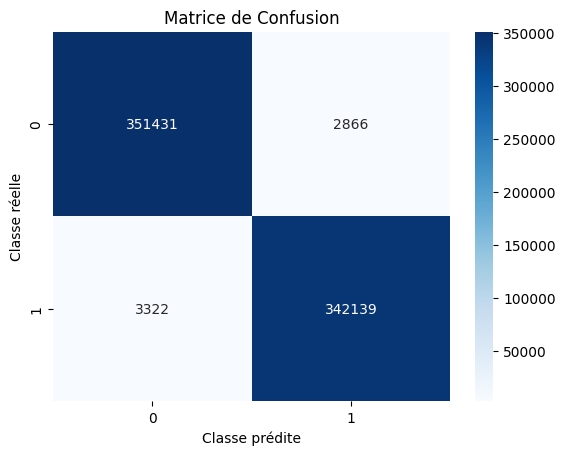

In [17]:
from sklearn.metrics import confusion_matrix
y_pred = Clf.predict(X_test_scaler)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de Confusion')
plt.show()

 # La courbe de ROC

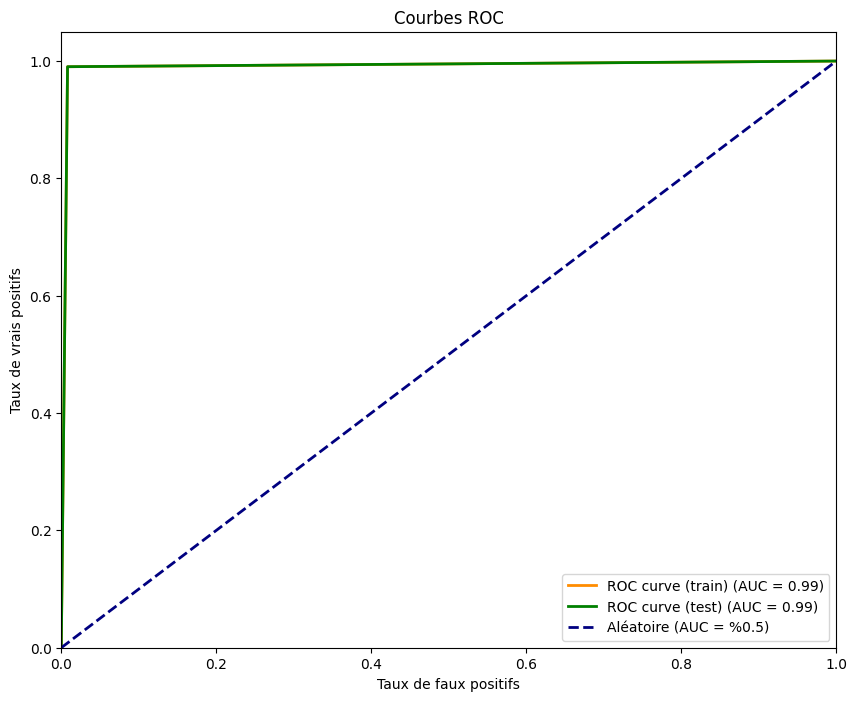

In [18]:
from sklearn.metrics import roc_curve, auc
# Obtenir les prédictions du modèle sur l'ensemble d'entraînement et de test
y_train_pred = Clf.predict(X_train_scaler)
y_test_pred = Clf.predict(X_test_scaler)

# Calculer les courbes ROC et les aires sous la courbe (AUC)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (AUC = %0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()

# Interpretabilité du modèle


###  Interpretabilité locale

####  I LIME

In [20]:
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=[0, 1],
                                 mode='classification')

In [21]:
i = X_test.iloc[0].values

exp = explainer.explain_instance(i, Clf.predict_proba)

exp.show_in_notebook(show_table=True)

#### II - Shapley Value

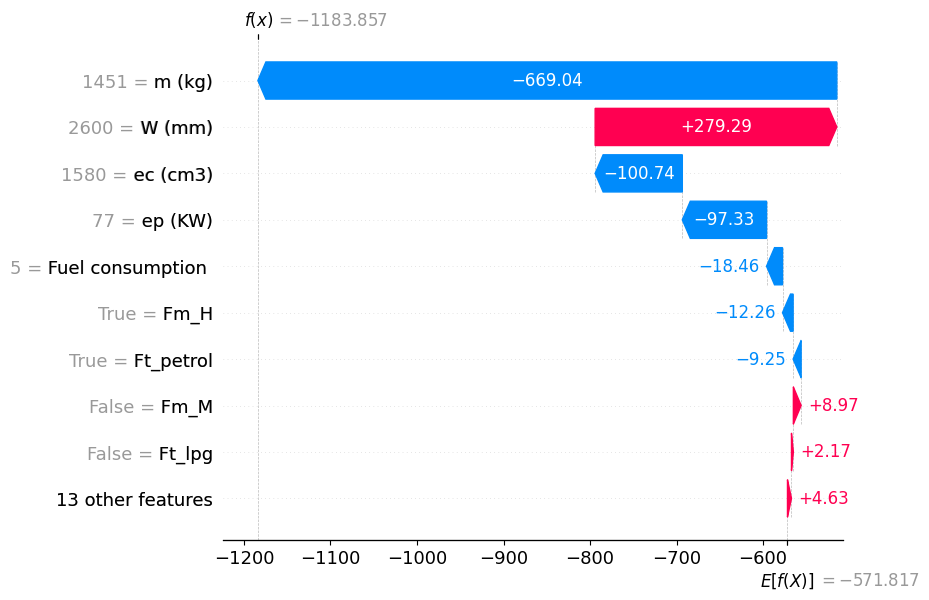

In [22]:
import shap

explainer = shap.LinearExplainer(Clf, X_train)

shap_values = explainer.shap_values(X_test)

shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test.iloc[0]))
plt.show()

### Interprétabilité globale

#### Importance des caractéristiques (Features importance)

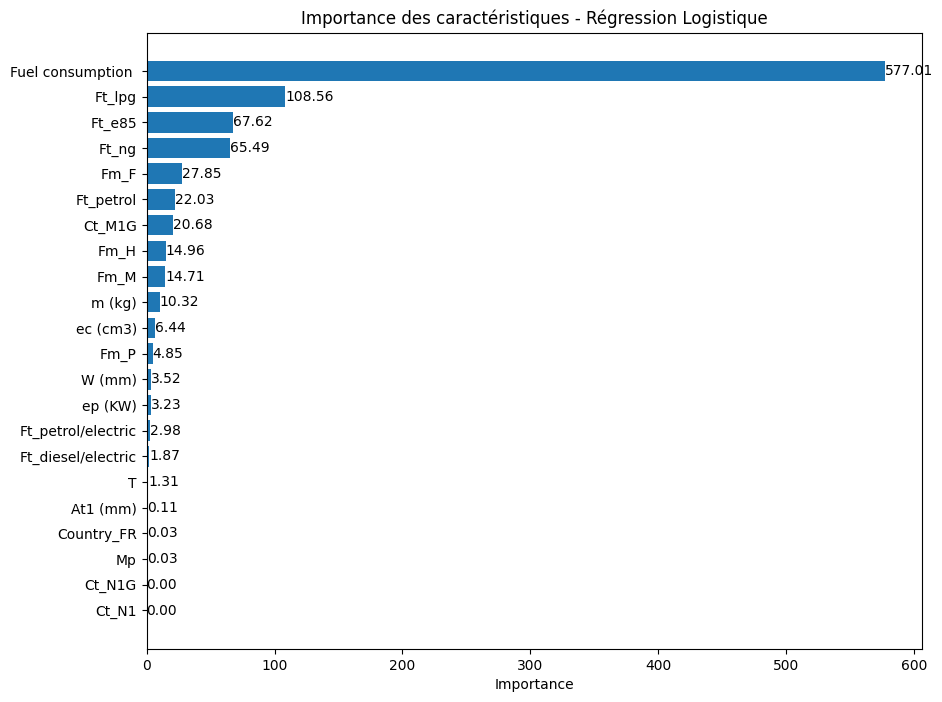

In [23]:
importance = np.abs(Clf.coef_[0])

sorted_indices = np.argsort(importance)
sorted_importance = importance[sorted_indices]
sorted_labels = X_test.columns[sorted_indices]

plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_labels)
plt.xlabel('Importance')
plt.title('Importance des caractéristiques - Régression Logistique')

for bar, value in zip(bars, sorted_importance):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')

plt.show()

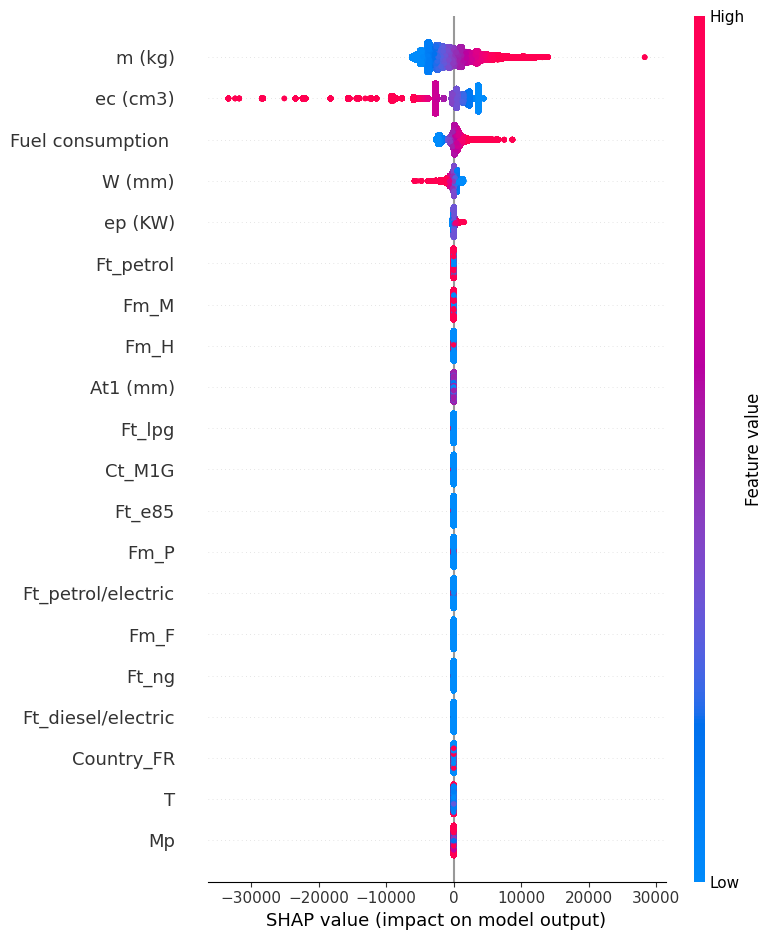

In [17]:
shap_values = np.array(shap_values, dtype=float)
shap.summary_plot(shap_values, X_test, plot_type="dot")